<h1><center>Mini Project 2: Word2vec and GloVe</center></h1>

## Importing the necessary libraries

In [1]:
!pip install gensim
import pandas as pd
import numpy as np

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the dataset

In [3]:
reviews = pd.read_csv("./Product_Reviews.csv")

In [4]:
data = reviews.copy()

## Data Overview

### Checking the first five rows of the data

In [5]:
data.head(5)

,Product ID,Product Review,Sentiment
0,AVpe7AsMilAPnD_xQ78G,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",POSITIVE
1,AVpe7AsMilAPnD_xQ78G,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",POSITIVE
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Had the original Fire since 2012. The Fire used to make my eyes hurt if I read too long. Haven't experienced that with the Paperwhite yet.,POSITIVE
3,AVpe7AsMilAPnD_xQ78G,"I bought one of the first Paperwhites and have been very pleased with it its been a constant companion and I suppose Ive read, on average, a book every three days for the past however many years on it. I wouldnt give it up youd have to pry it from my cold dead fingers.For sundry logistical reasons, Ive also made good use of Amazons Kindle app on my iPhone. No Paperwhite screen, naturally, and all the cool usability that delivers, but it works well and has its own attractions as a companion to the Kindle.Of course, there are aspects of the Paperwhite which I would like to critique. Ah you knew that was coming somewhere, didnt you.As a member of BookBub, I get a daily list of alerts and book deals in my chosen genres. I take on many of them, however, Ive found that, even with the best will in the world, I cant keep up. Some days it seems that for every book I read, Ive bought two. Theres just so much good stuff out there! The accumulative effect of this is that the number of books actually on my Paperwhite has been creeping ever upward for some time. Its now at about 400.With this in mind, Ive noticed that while page-turning has remained exactly the 

### Checking the shape of the dataset

In [6]:
data.shape

(1007, 3)

### Checking for Missing Values

In [7]:
data.isnull().sum()

Product ID        0
Product Review    0
Sentiment         0
dtype: int64

### Checking for duplicate values

In [8]:
data.duplicated().sum()

2

In [9]:
data = data.drop_duplicates()

data.duplicated().sum()

0

## Exploratory Data Analysis (EDA)


<Axes: xlabel='Sentiment', ylabel='count'>

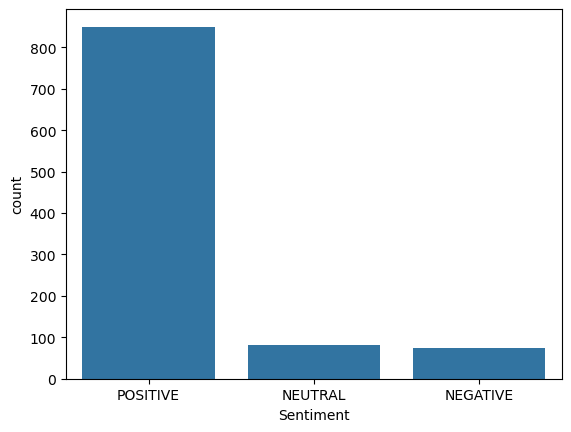

In [10]:
sns.countplot(data=data, x="Sentiment")

In [11]:
data['Sentiment'].value_counts(normalize=True)

Sentiment
POSITIVE    0.845771
NEUTRAL     0.080597
NEGATIVE    0.073632
Name: proportion, dtype: float64

## Text Preprocessing

### Removing special characters from the text

In [12]:
def remove_special_characters(text):
    pattern = '[^A-Za-z0-9]+'
    new_text = ''.join(re.sub(pattern, ' ', text))
    return new_text

In [13]:
data['cleaned_text'] = data['Product Review'].apply(remove_special_characters)

In [14]:
data.loc[0:3, ['Product Review','cleaned_text']]

,Product Review,cleaned_text
0,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage Fortunately I had friends who owned each so I ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment It s been a week and I am loving my paperwhite no regrets The touch screen is receptive and easy to use and I keep the light at a specific setting regardless of the time of day In any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading Also glad that I went for the international shipping option with Amazon Extra expense but delivery was on time with tracking and I didnt need to worry about customs which I may have if I used a third party shipping service
1,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",Allow me to preface this with a little history I am was a casual reader who owned a Nook Simple Touch from 2011 I ve read the Harry Potter series Girl with the Dragon Tattoo series 1984 Brave New World and a few other key titles Fair to say my Nook did not get as much use as many others may have gotten from theirs Fast forward to today I have had a full week with my new Kindle Paperwhite and I have to admit I m in love Not just w

- We can observe that the function removed the special characters and retained the alphabets and numbers.

### Lowercasing

In [15]:
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [16]:
data.loc[0:3, ['Product Review','cleaned_text']]

,Product Review,cleaned_text
0,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about customs which i may have if i used a third party shipping service
1,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",allow me to preface this with a little history i am was a casual reader who owned a nook simple touch from 2011 i ve read the harry potter series girl with the dragon tattoo series 1984 brave new world and a few other key titles fair to say my nook did not get as much use as many others may have gotten from theirs fast forward to today i have had a full week with my new kindle paperwhite and i have to admit i m in love not just w

### Removing extra whitespace

In [17]:
data['cleaned_text'] = data['cleaned_text'].str.strip()

In [18]:
data.loc[0:3, ['Product Review','cleaned_text']]

,Product Review,cleaned_text
0,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about customs which i may have if i used a third party shipping service
1,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",allow me to preface this with a little history i am was a casual reader who owned a nook simple touch from 2011 i ve read the harry potter series girl with the dragon tattoo series 1984 brave new world and a few other key titles fair to say my nook did not get as much use as many others may have gotten from theirs fast forward to today i have had a full week with my new kindle paperwhite and i have to admit i m in love not just w

### Removing stopwords

In [19]:
def remove_stopwords(text):
    words = text.split()
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])
    return new_text

In [20]:
data['cleaned_text_without_stopwords'] = data['cleaned_text'].apply(remove_stopwords)

In [21]:
data.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about customs which i may have if i used a third party shipping service,initially trouble deciding paperwhite voyage reviews less said thing paperwhite great spending money go voyage fortunately friends owned ended buying paperwhite basis models 300 ppi 80 dollar jump turns pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regrets touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry customs may used third party shipping service
1,allow me to preface this with a little history i am was a casual reader who owned a nook simple touch from 2011 i ve read the harry potter series girl with the dragon tattoo series 1984 brave new world and a few other key titles fair to say my nook did not get as much use as many others may have gotten from theirs fast forward to today i have had a full week with my new kindle paperwhite and i have to admit i m in love not just with the kindle but with reading all over again now let me relate this review love and reading all back to the kindle the investment of 139 00 is in the experience you will receive when you buy a kindle you are not simply paying for a screen there is an entire experience included in buying from amazon i have been reading the hunger games trilogy and shall be moving onto the divergent series soon after here is the thing with the nook that hindered me for the past 4 years i was never inspired to pick it up get it into my hands and just dive in there was never that feeling of oh man reading on this thing is so awesome however with my paperwhite i now have that feeling that desire is back and i simply adore my kindle if you are considering purchasing one stop thinking about it simply go for it after a full week 3 downloaded books and a ton of reading i still have half of my battery left as well make yourself happy inspire the reader inside of you,allow preface little history casual reader owned nook simple touch 2011 read harry potter series girl dragon tattoo series 1984 brave new world key titles fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment 139 00 experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger games trilogy shall moving onto divergent series soon thing nook hindered past 4 years never inspired pick get hands dive never feeling oh man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply go full week 3 downloaded books ton reading still half battery left well make happy inspire reader inside
2,i am enjoying it so far great for reading had the o

### Stemming/Lemmatization

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def apply_lemmatizer(text):
    words = text.split()
    new_text = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return new_text

[nltk_data] Downloading package wordnet to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
data['final_cleaned_text'] = data['cleaned_text_without_stopwords'].apply(apply_lemmatizer)

In [24]:
data.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,initially trouble deciding paperwhite voyage reviews less said thing paperwhite great spending money go voyage fortunately friends owned ended buying paperwhite basis models 300 ppi 80 dollar jump turns pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regrets touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry customs may used third party shipping service,initially trouble deciding paperwhite voyage review less said thing paperwhite great spending money go voyage fortunately friend owned ended buying paperwhite basis model 300 ppi 80 dollar jump turn pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regret touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry custom may used third party shipping service
1,allow preface little history casual reader owned nook simple touch 2011 read harry potter series girl dragon tattoo series 1984 brave new world key titles fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment 139 00 experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger games trilogy shall moving onto divergent series soon thing nook hindered past 4 years never inspired pick get hands dive never feeling oh man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply go full week 3 downloaded books ton reading still half battery left well make happy inspire reader inside,allow preface little history casual reader owned nook simple touch 2011 read harry potter series girl dragon tattoo series 1984 brave new world key title fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment 139 00 experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger game trilogy shall moving onto divergent series soon thing nook hindered past 4 year never inspired pick get hand dive never feeling oh man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply go full week 3 downloaded book ton reading still half battery left well make happy inspire reader inside
2,enjoying far great reading original fire since 2012 fire used make eyes hurt read long experienced paperwhite yet,enjoying far great reading original fire since 2012 fire used make eye hurt read long experienced paperwhite yet


In [25]:
data.isnull().sum()

Product ID                        0
Product Review                    0
Sentiment                         0
cleaned_text                      0
cleaned_text_without_stopwords    0
final_cleaned_text                0
dtype: int64

In [26]:
data.loc[219]

Product ID                        AVsRjfwAU2_QcyX9PHqe
Product Review                                     Too
Sentiment                                     NEGATIVE
cleaned_text                                       too
cleaned_text_without_stopwords                        
final_cleaned_text                                    
Name: 219, dtype: object

## Text Vectorization

### 1.Count Vectorizer

In [27]:
data['final_cleaned_text'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      initially trouble deciding paperwhite voyage review less said thing paperwhite great spending money go voyage fortunately friend owned ended buying paperwhite basis model 300 ppi 80 dollar jump turn pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regret touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad wen

In [28]:
bow_vec = CountVectorizer(max_features = 1000)
data_features_BOW = bow_vec.fit_transform(data['final_cleaned_text'])

data_features_BOW = data_features_BOW.toarray()
print("Shape of the feature vector",data_features_BOW.shape)

words = bow_vec.get_feature_names_out()

print("first 10 words",words[:10])
print("last 10 words",words[-10:])

df_BOW = pd.DataFrame(data_features_BOW, columns=bow_vec.get_feature_names_out())
df_BOW.head()


Shape of the feature vector (1005, 1000)
first 10 words ['10' '100' '11' '139' '15' '16' '17' '20' '2013' '2014']
last 10 words ['worth' 'would' 'write' 'writing' 'wrong' 'year' 'yes' 'yet' 'youll'
 'youtube']


,10,100,11,139,15,16,17,20,2013,2014,...,worth,would,write,writing,wrong,year,yes,yet,youll,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### 2.Word2Vec

### 2.1 CBOW

In [29]:
from gensim.models import Word2Vec

sentences = [
    ["the", "cat", "sat", "on", "the", "mat"],
    ["the", "dog", "sat", "on", "the", "rug"],
    ["cat", "and", "dog", "are", "friends"],
    ["the", "puppy", "played", "with", "the", "ball"],
    ["the", "kitten", "played", "with", "the", "yarn"]
]



cbow_model = Word2Vec(sentences, vector_size=10, window=2, min_count=1, sg=0)
print("Vector for 'cat':")
print(cbow_model.wv['cat'])
print("\nWords similar to 'cat'and the cosine of angles between those vectors:")
print(cbow_model.wv.most_similar('cat'))


Vector for 'cat':
[-0.01577653  0.00321372 -0.0414063  -0.07682689 -0.01508008  0.02469795
 -0.00888027  0.05533662 -0.02742977  0.02260065]

Words similar to 'cat'and the cosine of angles between those vectors:
[('on', 0.6143898963928223), ('are', 0.3861965239048004), ('and', 0.2201869934797287), ('yarn', 0.1973467767238617), ('rug', 0.1793583631515503), ('mat', 0.12150013446807861), ('friends', 0.1153423935174942), ('sat', -0.042645372450351715), ('played', -0.08937528729438782), ('dog', -0.11393023282289505)]


In [30]:
print(cbow_model.wv['dog'])
print("\nWords similar to 'dog'and the cosine of angles between those vectors:")
print(cbow_model.wv.most_similar('dog'))

[-0.07512426 -0.00929962  0.0953928  -0.07318163 -0.02333458 -0.01937735
  0.0807736  -0.05931413  0.00044939 -0.04753005]

Words similar to 'dog'and the cosine of angles between those vectors:
[('yarn', 0.2940610349178314), ('kitten', 0.2071666270494461), ('puppy', 0.19908407330513), ('the', 0.1050160825252533), ('sat', 0.09271864593029022), ('are', 0.057593297213315964), ('played', -0.1055053099989891), ('cat', -0.11393020302057266), ('and', -0.19232362508773804), ('with', -0.21132361888885498)]


### 2.2 Skip-gram

In [31]:
from gensim.models import Word2Vec

sentences = [
    ["the", "cat", "sat", "on", "the", "mat"],
    ["the", "dog", "sat", "on", "the", "rug"],
    ["cat", "and", "dog", "are", "friends"],
    ["the", "puppy", "played", "with", "the", "ball"],
    ["the", "kitten", "played", "with", "the", "yarn"]
]


model = Word2Vec(sentences, vector_size=10, window=2, min_count=1, sg=1)

print(model.wv['cat'])
print(model.wv.most_similar('cat'))


[-0.01577653  0.00321372 -0.0414063  -0.07682689 -0.01508008  0.02469795
 -0.00888027  0.05533662 -0.02742977  0.02260065]
[('on', 0.6143749952316284), ('are', 0.3861807584762573), ('and', 0.22012634575366974), ('yarn', 0.19724483788013458), ('rug', 0.1793583631515503), ('mat', 0.12150013446807861), ('friends', 0.1153423935174942), ('sat', -0.042645372450351715), ('played', -0.08937528729438782), ('dog', -0.11396104842424393)]


In [32]:
a='apple is a fruit'
a.split()

['apple', 'is', 'a', 'fruit']

In [33]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

sentences = data['final_cleaned_text'].apply(lambda x: x.split())  # assuming text is already cleaned

cbow_model = Word2Vec(
    sentences,
    vector_size=100,
    window=3,
    min_count=5,
    sg=0,
    workers=4
)

skipgram_model = Word2Vec(
    sentences,
    vector_size=100,
    window=3,
    min_count=5,
    sg=1,
    workers=4
)

def get_sentence_vector(model, tokens):
    word_vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vecs, axis=0)

data_cbow_vectors = np.array([get_sentence_vector(cbow_model, tokens) for tokens in sentences])
data_skipgram_vectors = np.array([get_sentence_vector(skipgram_model, tokens) for tokens in sentences])

df_cbow = pd.DataFrame(data_cbow_vectors)
df_skipgram = pd.DataFrame(data_skipgram_vectors)




In [34]:
df_cbow.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.222164,0.383083,0.168974,-0.102190,0.107458,-0.409170,0.195768,0.440174,-0.097769,-0.255361,...,0.348360,0.030727,0.102940,0.031390,0.403657,0.262030,-0.020160,-0.361024,0.010925,-0.140537
1,-0.226533,0.390112,0.174747,-0.100495,0.108692,-0.415933,0.199229,0.449578,-0.103644,-0.259119,...,0.358883,0.031492,0.105437,0.031118,0.413038,0.269132,-0.017841,-0.367982,0.011011,-0.144546
2,-0.241650,0.412852,0.186398,-0.107885,0.119429,-0.441496,0.212983,0.476544,-0.115603,-0.266671,...,0.388338,0.038086,0.118885,0.031352,0.446100,0.289962,-0.017383,-0.392573,0.013732,-0.158827
3,-0.223635,0.383801,0.172188,-0.099014,0.106909,-0.408749,0.195875,0.439880,-0.099891,-0.255634,...,0.350778,0.032356,0.102828,0.029959,0.405770,0.263046,-0.018423,-0.359582,0.011169,-0.140773
4,-0.258432,0.446579,0.196901,-0.116191,0.122910,-0.472827,0.227799,0.513546,-0.116132,-0.297082,...,0.404835,0.036498,0.118320,0.036329,0.470026,0.303852,-0.021818,-0.418657,0.014619,-0.162010


In [35]:
print("CBOW:",cbow_model.wv.similar_by_word('book', topn=5))
print("SkipGram:",skipgram_model.wv.similar_by_word('book', topn=5))


CBOW: [('oasis', 0.9993016123771667), ('day', 0.9992655515670776), ('start', 0.9992300868034363), ('many', 0.9992194175720215), ('able', 0.9992185831069946)]
SkipGram: [('reading', 0.9553399085998535), ('read', 0.9136415719985962), ('digital', 0.9127656817436218), ('including', 0.9102397561073303), ('category', 0.9017625451087952)]


In [36]:
print("CBOW:",cbow_model.wv.similar_by_word('review', topn=5))
print("SkipGram:",skipgram_model.wv.similar_by_word('review', topn=5))

CBOW: [('voyage', 0.9994421005249023), ('also', 0.9993593096733093), ('read', 0.9993515610694885), ('user', 0.9993422031402588), ('since', 0.9993303418159485)]
SkipGram: [('keyboard', 0.9722393155097961), ('gb', 0.9720422029495239), ('2014', 0.970499575138092), ('139', 0.970013439655304), ('comparison', 0.9693495035171509)]


### 2.3 GloVe

In [42]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec('glove.6B.100d.txt','word2vec.glove.6B.100d.txt')
glove_model = KeyedVectors.load_word2vec_format('word2vec.glove.6B.100d.txt')

C:\Users\Rishi Thakur\AppData\Local\Temp\ipykernel_24932\4251565952.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('glove.6B.100d.txt','word2vec.glove.6B.100d.txt')


In [43]:
# Checking top 5 similar words to the word 'book' by GloVe model
print("word embedding of word book", glove_model['book'])
print("GloVe:",glove_model.similar_by_word('book', topn=5))

word embedding of word book [-1.9744e-01  4.4831e-01  1.3689e-01 -1.5595e-01  9.3600e-01  7.2986e-01
  3.4099e-01 -3.3896e-01 -8.9569e-02 -4.7706e-01  3.5112e-01 -4.2198e-01
 -1.2221e-01 -6.3375e-02 -4.5820e-01  7.8723e-01  9.4045e-01  8.1101e-02
 -2.3224e-01  4.0778e-01  3.3258e-01 -4.4458e-01 -4.7117e-01  1.4852e-01
  9.6308e-01 -6.5267e-02 -5.3661e-02 -6.7474e-01 -4.2364e-01  9.4392e-02
 -3.8668e-01  1.8237e-01 -1.2846e-01 -2.1952e-01 -5.8993e-01  7.3602e-01
 -2.4009e-01  3.2392e-01 -2.4663e-01 -4.0684e-01 -5.2468e-01  4.6174e-01
 -1.4936e-01 -1.1999e-01 -1.3990e-01 -4.4944e-01 -2.6565e-01 -7.0061e-01
  3.0188e-01 -1.1209e-01  6.6323e-01  3.9698e-01  6.9158e-01  8.3442e-01
 -5.2717e-01 -2.5314e+00  1.3281e-01  3.0253e-01  1.1062e+00  7.2221e-03
  2.6031e-01  1.1584e+00 -7.9330e-02 -7.6659e-01  1.2623e+00 -6.2071e-01
  5.9821e-01  7.3539e-01  3.8573e-01 -4.0293e-01 -3.1440e-02  7.7863e-01
  3.1525e-01  1.9003e-01 -6.5821e-01  4.0548e-01  5.3596e-03  5.5274e-02
 -1.2238e+00 -4.8912e-0

In [44]:
"apple"

'apple'

In [45]:
words

array(['10', '100', '11', '139', '15', '16', '17', '20', '2013', '2014',
       '2015', '2017', '212', '24', '2nd', '30', '300', '36weight', '3rd',
       '4gbpage', '50', '60', '6x0', '7x4', '80', '89', '90', '99',
       'ability', 'able', 'absolutely', 'access', 'account', 'accurate',
       'across', 'activate', 'activated', 'actually', 'ad', 'adapter',
       'add', 'added', 'adding', 'addition', 'additional', 'adjust',
       'adjustable', 'age', 'ago', 'alarm', 'alexa', 'allow', 'allows',
       'almost', 'along', 'already', 'also', 'although', 'always',
       'amazing', 'amazon', 'amount', 'android', 'annoying', 'another',
       'answer', 'anyone', 'anything', 'anyway', 'anywhere', 'app',
       'appears', 'apple', 'apps', 'area', 'around', 'arrived', 'ask',
       'asked', 'asking', 'aspect', 'attached', 'attention', 'audio',
       'automatically', 'available', 'away', 'awesome', 'back',
       'background', 'bad', 'bag', 'band', 'base', 'based', 'basic',
       'basically'

In [46]:
words = glove_model.index_to_key

word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

vec_size=100

def average_vectorizer_GloVe(doc):
    feature_vector = np.zeros((vec_size,), dtype="float64")

    words_in_vocab = [word for word in doc.split() if word in words]
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    if len(words_in_vocab) != 0:
        feature_vector= feature_vector/len(words_in_vocab)

    return feature_vector

df_glove = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,-0.053155,0.216505,0.195780,-0.031357,-0.048753,-0.055434,-0.132714,0.154555,-0.080816,-0.042809,...,-0.110735,0.047534,0.051719,-0.153488,-0.379543,0.043050,-0.064809,-0.151182,0.406266,0.079312
1,-0.066151,0.230377,0.282352,-0.166520,0.039604,0.217779,-0.046976,0.044165,0.002549,-0.143035,...,-0.088376,0.114199,0.048469,-0.042053,-0.400007,-0.058386,-0.080953,-0.167530,0.337013,0.153224
2,-0.106081,0.223212,0.132544,-0.122038,-0.069432,0.091704,-0.020032,0.045129,-0.075261,-0.119964,...,0.124861,-0.090759,-0.131422,0.100330,-0.519563,0.041313,-0.242947,-0.090972,0.374808,0.014598
3,-0.136231,0.244225,0.223648,-0.090145,0.002741,0.125460,0.037123,0.046425,0.033456,-0.152055,...,-0.018635,0.109786,-0.023671,-0.088792,-0.356975,-0.060596,-0.125712,-0.202285,0.252326,0.224924
4,-0.135729,0.284206,0.257785,-0.128487,0.107000,0.109005,-0.063350,0.070573,0.104571,-0.055122,...,0.058215,0.049815,-0.040230,-0.082259,-0.364913,0.020126,-0.154012,-0.143547,0.381477,0.090854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.186420,-0.049936,0.463003,-0.084825,0.029066,-0.180104,-0.069910,0.149820,0.030971,-0.110175,...,0.154890,0.051570,-0.082908,-0.091199,-0.285825,0.093452,-0.136089,-0.291654,0.214120,0.045435
1001,-0.164451,0.093684,0.307945,-0.042334,-0.041959,0.001777,0.121589,0.246116,-0.029657,0.087993,...,0.000342,0.011940,-0.015269,-0.123950,-0.355829,0.070308,0.002449,-0.052865,0.546032,0.012885
1002,-0.305274,0.112491,0.341010,-0.017033,0.172328,-0.009432,-0.113842,0.211076,0.160144,0.206710,...,-0.083836,0.107675,0.025984,-0.303324,-0.286351,-0.080664,0.030847,-0.046204,0.415141,-0.259191
1003,-0.010796,0.352242,0.323295,-0.171241,-0.152838,-0.129148,-0.060815,0.213803,-0.179559,0.028706,...,0.005970,0.088560,0.042328,-0.397525,-0.574539,-0.018921,-0.102332,0.000802,0.520649,0.043535


## Building Models

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
vectorized_datasets = [
    ("BoW", df_BOW),
    ("GloVe", df_glove),
    ("word2Vec_cbow",df_cbow),
    ("skipgram",df_skipgram)
]

y = data['Sentiment']

results = []

for name, X in vectorized_datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    rf_model = RandomForestClassifier(random_state=100)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_f1 = f1_score(y_test, rf_preds, average='macro')
    results.append((f"RandomForest - {name}", rf_f1, rf_model, X_test, y_test, rf_preds))


    from sklearn.ensemble import GradientBoostingClassifier
    gboost = GradientBoostingClassifier(random_state=100)
    gboost.fit(X_train, y_train)
    gb_preds = gboost.predict(X_test)
    gb_f1 = f1_score(y_test, gb_preds, average='macro')
    results.append((f"Gradient Boost - {name}", gb_f1, gboost, X_test, y_test, gb_preds))

    from sklearn.ensemble import AdaBoostClassifier
    ada = AdaBoostClassifier()
    ada.fit(X_train, y_train)
    ada_preds = ada.predict(X_test)
    ada_f1 = f1_score(y_test, ada_preds, average='macro')
    results.append((f"Adaptive Boost - {name}", ada_f1, ada, X_test, y_test, ada_preds))

results.sort(key=lambda x: x[1], reverse=True)

print("\nModel Performance (Macro F1-scores):\n")
for label, f1_score_val, _, _, _, _ in results:
    print(f"{label:30s}: Macro F1 = {f1_score_val:.4f}")





📊 Model Performance (Macro F1-scores):

Gradient Boost - BoW          : Macro F1 = 0.6442
RandomForest - skipgram       : Macro F1 = 0.5388
RandomForest - GloVe          : Macro F1 = 0.5138
Gradient Boost - skipgram     : Macro F1 = 0.5081
RandomForest - BoW            : Macro F1 = 0.4818
Gradient Boost - GloVe        : Macro F1 = 0.4776
Gradient Boost - word2Vec_cbow: Macro F1 = 0.4682
RandomForest - word2Vec_cbow  : Macro F1 = 0.4461
Adaptive Boost - GloVe        : Macro F1 = 0.3715
Adaptive Boost - skipgram     : Macro F1 = 0.3562
Adaptive Boost - word2Vec_cbow: Macro F1 = 0.3035
Adaptive Boost - BoW          : Macro F1 = 0.3025



✅ Best Model: Gradient Boost - BoW (Macro F1 = 0.6442)

Classification Report:

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.44      0.56        16
     NEUTRAL       0.83      0.29      0.43        17
    POSITIVE       0.89      0.99      0.94       168

    accuracy                           0.89       201
   macro avg       0.83      0.57      0.64       201
weighted avg       0.88      0.89      0.87       201



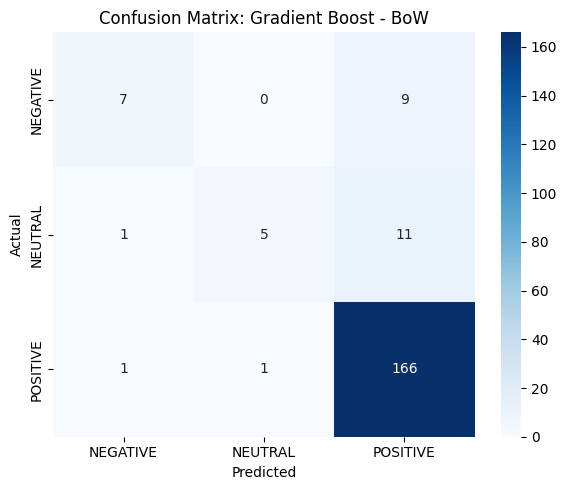

In [ ]:
best_model_label, best_f1, best_model, X_test_best, y_test_best, y_pred_best = results[0]

print(f"\nBest Model: {best_model_label} (Macro F1 = {best_f1:.4f})\n")
print("Classification Report:\n")
print(classification_report(y_test_best, y_pred_best))

cm = confusion_matrix(y_test_best, y_pred_best, labels=best_model.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f"Confusion Matrix: {best_model_label}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()